In [2]:
from copy import deepcopy
from dataclasses import dataclass
from typing import Optional, List, Tuple
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

from alns import ALNS
from alns.accept import SimulatedAnnealing
from alns.select import AlphaUCB
from alns.stop import MaxIterations, MaxRuntime

# Set random seed for reproducibility
SEED = 2345
rnd.seed(SEED)

@dataclass
class Data:
    n_jobs: int
    n_machines: int
    bkv: int  # best known value
    processing_times: np.ndarray

    @classmethod
    def from_file(cls, path):
        with open(path, "r") as fi:
            lines = fi.readlines()

            n_jobs, n_machines, _, bkv, _ = [
                int(num) for num in lines[1].split()
            ]
            processing_times = np.genfromtxt(lines[3:], dtype=int)

            return cls(n_jobs, n_machines, bkv, processing_times)


def compute_completion_times(schedule):
    """
    Compute the completion time for each job of the passed-in schedule.
    """
    completion = np.zeros(DATA.processing_times.shape, dtype=int)

    for idx, job in enumerate(schedule):
        for machine in range(DATA.n_machines):
            prev_job = completion[machine, schedule[idx - 1]] if idx > 0 else 0
            prev_machine = completion[machine - 1, job] if machine > 0 else 0
            processing = DATA.processing_times[machine, job]

            completion[machine, job] = max(prev_job, prev_machine) + processing

    return completion


def compute_makespan(schedule):
    """
    Returns the makespan, i.e., the maximum completion time.
    """
    return compute_completion_times(schedule)[-1, schedule[-1]]


def plot(schedule, name):
    """
    Plots a Gantt chart of the schedule for the permutation flow shop problem.
    """
    n_machines, n_jobs = DATA.processing_times.shape

    completion = compute_completion_times(schedule)
    start = completion - DATA.processing_times

    # Plot each job using its start and completion time
    cmap = plt.colormaps["rainbow"].resampled(n_jobs)
    machines, length, start_job, job_colors = zip(
        *[
            (i, DATA.processing_times[i, j], start[i, j], cmap(j - 1))
            for i in range(n_machines)
            for j in range(n_jobs)
        ]
    )

    _, ax = plt.subplots(1, figsize=(12, 6))
    ax.barh(machines, length, left=start_job, color=job_colors)

    ax.set_title(f"{name}\n Makespan: {compute_makespan(schedule)}")
    ax.set_ylabel(f"Machine")
    ax.set_xlabel(f"Completion time")
    ax.set_yticks(range(DATA.n_machines))
    ax.set_yticklabels(range(1, DATA.n_machines + 1))
    ax.invert_yaxis()

    plt.show()


class Solution:
    def __init__(
        self, schedule: List[int], unassigned: Optional[List[int]] = None
    ):
        self.schedule = schedule
        self.unassigned = unassigned if unassigned is not None else []

    def objective(self):
        return compute_makespan(self.schedule)

    def insert(self, job: int, idx: int):
        self.schedule.insert(idx, job)

    def opt_insert(self, job: int):
        """
        Optimally insert the job in the current schedule.
        """
        idcs_costs = all_insert_cost(self.schedule, job)
        idx, _ = min(idcs_costs, key=lambda idx_cost: idx_cost[1])
        self.insert(job, idx)

    def remove(self, job: int):
        self.schedule.remove(job)


def all_insert_cost(schedule: List[int], job: int) -> List[Tuple[int, float]]:
    """
    Computes all partial makespans when inserting a job in the schedule.
    O(nm) using Taillard's acceleration. Returns a list of tuples of the
    insertion index and the resulting makespan.

    [1] Taillard, E. (1990). Some efficient heuristic methods for the
    flow shop sequencing problem. European Journal of Operational Research,
    47(1), 65-74.
    """
    k = len(schedule) + 1
    m = DATA.processing_times.shape[0]
    p = DATA.processing_times

    # Earliest completion of schedule[j] on machine i before insertion
    e = np.zeros((m + 1, k))
    for j in range(k - 1):
        for i in range(m):
            e[i, j] = max(e[i, j - 1], e[i - 1, j]) + p[i, schedule[j]]

    # Duration between starting time and final makespan
    q = np.zeros((m + 1, k))
    for j in range(k - 2, -1, -1):
        for i in range(m - 1, -1, -1):
            q[i, j] = max(q[i + 1, j], q[i, j + 1]) + p[i, schedule[j]]

    # Earliest relative completion time
    f = np.zeros((m + 1, k))
    for l in range(k):
        for i in range(m):
            f[i, l] = max(f[i - 1, l], e[i, l - 1]) + p[i, job]

    # Partial makespan; drop the last (dummy) row of q
    M = np.max(f + q, axis=0)

    return [(idx, M[idx]) for idx in np.argsort(M)]


def random_removal(state: Solution, rng, n_remove=2) -> Solution:
    """
    Randomly remove a number jobs from the solution.
    """
    destroyed = deepcopy(state)

    for job in rng.choice(DATA.n_jobs, n_remove, replace=False):
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)

    return destroyed


def adjacent_removal(state: Solution, rng, n_remove=2) -> Solution:
    """
    Randomly remove a number adjacent jobs from the solution.
    """
    destroyed = deepcopy(state)

    start = rng.integers(DATA.n_jobs - n_remove)
    jobs_to_remove = [state.schedule[start + idx] for idx in range(n_remove)]

    for job in jobs_to_remove:
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)

    return destroyed


def greedy_repair(state: Solution, rng, **kwargs) -> Solution:
    """
    Greedily insert the unassigned jobs back into the schedule. The jobs are
    inserted in non-decreasing order of total processing times.
    """
    state.unassigned.sort(key=lambda j: sum(DATA.processing_times[:, j]))

    while len(state.unassigned) != 0:
        job = state.unassigned.pop()  # largest total processing time first
        state.opt_insert(job)

    return state


def local_search(solution: Solution, **kwargs):
    """
    Improves the current solution in-place using the insertion neighborhood.
    A random job is selected and put in the best new position. This continues
    until relocating any of the jobs does not lead to an improving move.
    """
    improved = True

    while improved:
        improved = False
        current = solution.objective()

        for job in rnd.choice(
            solution.schedule, len(solution.schedule), replace=False
        ):
            solution.remove(job)
            solution.opt_insert(job)

            if solution.objective() < current:
                improved = True
                current = solution.objective()
                break


def greedy_repair_then_local_search(state: Solution, rng, **kwargs):
    """
    Greedily insert the unassigned jobs back into the schedule (using NEH
    ordering). Apply local search afterwards.
    """
    state = greedy_repair(state, rng, **kwargs)
    local_search(state, **kwargs)
    return state


def NEH(processing_times: np.ndarray) -> Solution:
    """
    Schedules jobs in decreasing order of the total processing times.

    [1] Nawaz, M., Enscore Jr, E. E., & Ham, I. (1983). A heuristic algorithm
    for the m-machine, n-job flow-shop sequencing problem. Omega, 11(1), 91-95.
    """
    largest_first = np.argsort(processing_times.sum(axis=0)).tolist()[::-1]
    solution = Solution([largest_first.pop(0)], [])

    for job in largest_first:
        solution.opt_insert(job)

    return solution



Processing instance: j20_m5_01 (Type: j20_m5)
  Running Baseline...
    Objective: 1286, Gap: 0.63%, Time: 0.38s
  Running Claude...
    Objective: 1286, Gap: 0.63%, Time: 0.98s
  Running CHATGPT...
    Objective: 1286, Gap: 0.63%, Time: 0.38s

Processing instance: j20_m5_02 (Type: j20_m5)
  Running Baseline...
    Objective: 1360, Gap: 0.07%, Time: 0.37s
  Running Claude...
    Objective: 1365, Gap: 0.44%, Time: 1.11s
  Running CHATGPT...
    Objective: 1360, Gap: 0.07%, Time: 0.41s

Processing instance: j20_m5_03 (Type: j20_m5)
  Running Baseline...
    Objective: 1087, Gap: 0.56%, Time: 0.37s
  Running Claude...
    Objective: 1121, Gap: 3.70%, Time: 0.95s
  Running CHATGPT...
    Objective: 1089, Gap: 0.74%, Time: 0.37s

Processing instance: j20_m5_04 (Type: j20_m5)
  Running Baseline...
    Objective: 1299, Gap: 0.46%, Time: 0.35s
  Running Claude...
    Objective: 1325, Gap: 2.47%, Time: 0.96s
  Running CHATGPT...
    Objective: 1298, Gap: 0.39%, Time: 0.36s

Processing instance

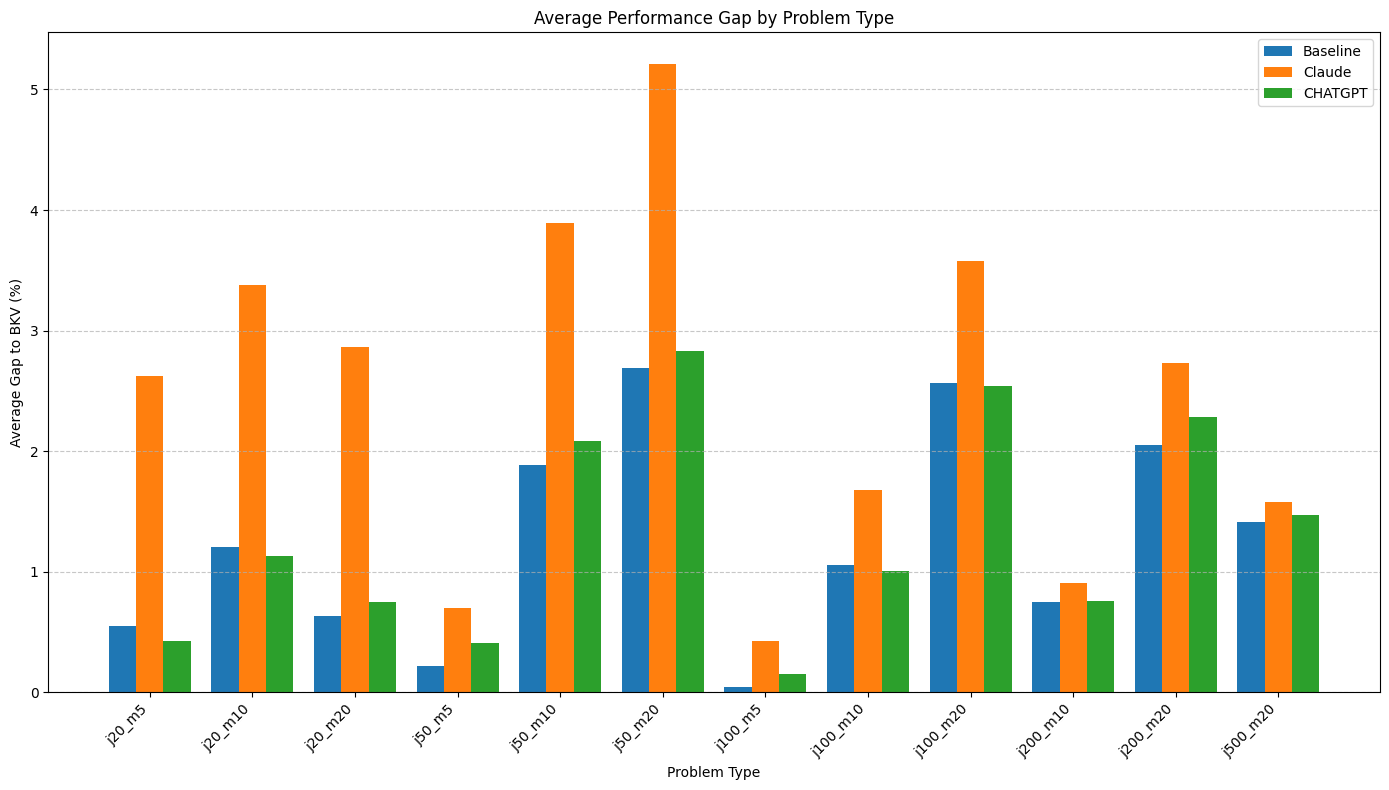

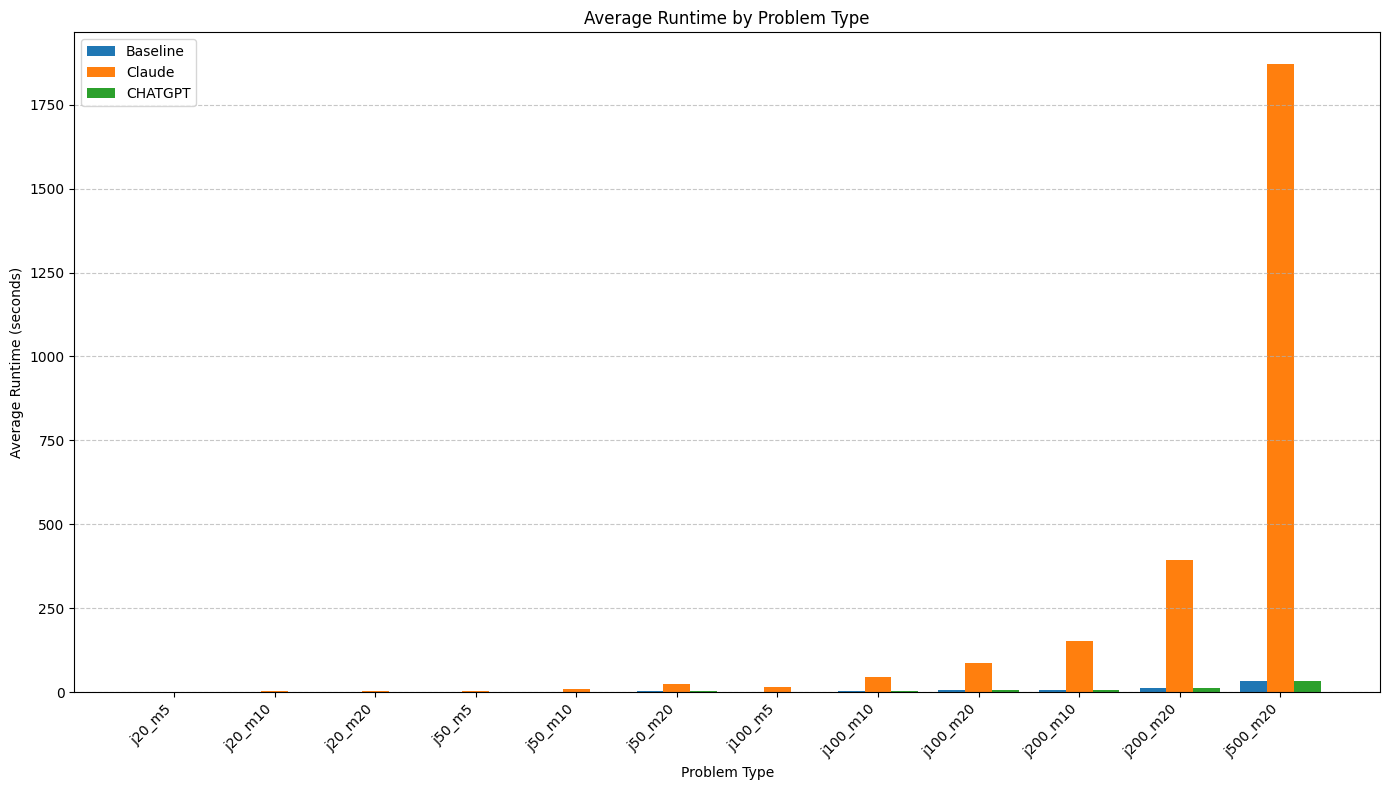

,Problem_Type,Baseline_AvgGap,Claude_AvgGap,CHATGPT_AvgGap
0,j20_m5,0.550648,2.622561,0.429205
1,j20_m10,1.203127,3.377981,1.130594
2,j20_m20,0.634985,2.862641,0.746679
3,j50_m5,0.221258,0.703193,0.409280
4,j50_m10,1.886648,3.888741,2.083210
5,j50_m20,2.690297,5.213012,2.831316
6,j100_m5,0.047479,0.421413,0.149806
7,j100_m10,1.058304,1.680215,1.006746
8,j100_m20,2.568164,3.578964,2.544217
9,j200_m10,0.746545,0.904876,0.758434


,Approach,Avg Gap (%),Best Gap (%),Worst Gap (%),Avg Time (s)
0,Baseline,1.256484,-0.215433,3.796424,6.196224
1,Claude,2.463738,0.077897,6.135630,218.243174
2,CHATGPT,1.320445,-0.018335,3.356259,6.011330


,Instance,Problem_Type,Size,BKV,Baseline_Obj,Baseline_Gap,Baseline_Time,Claude_Obj,Claude_Gap,Claude_Time,CHATGPT_Obj,CHATGPT_Gap,CHATGPT_Time
0,j20_m5_01,j20_m5,20x5,1278,1286,0.625978,0.378900,1286,0.625978,0.977287,1286,0.625978,0.380670
1,j20_m5_02,j20_m5,20x5,1359,1360,0.073584,0.371638,1365,0.441501,1.106379,1360,0.073584,0.407500
2,j20_m5_03,j20_m5,20x5,1081,1087,0.555042,0.370607,1121,3.700278,0.948106,1089,0.740056,0.373279
3,j20_m5_04,j20_m5,20x5,1293,1299,0.464037,0.352572,1325,2.474865,0.958101,1298,0.386698,0.364506
4,j20_m5_05,j20_m5,20x5,1236,1235,-0.080906,0.360335,1305,5.582524,1.171770,1244,0.647249,0.353688
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,j500_m20_06,j500_m20,500x20,26581,26882,1.132388,34.124609,26948,1.380685,508.445855,26929,1.309206,32.222517
116,j500_m20_07,j500_m20,500x20,26461,26733,1.027928,32.033992,26737,1.043044,1985.481461,26752,1.099732,32.264814
117,j500_m20_08,j500_m20,500x20,26615,27068,1.702048,32.215584,27006,1.469096,2519.807596,27022,1.529213,32.624440
118,j500_m20_09,j500_m20,500x20,26083,26521,1.679255,32.118519,26484,1.537400,2664.775859,26502,1.606410,32.294640


In [10]:
def run_benchmark(data_files, approaches, seed=SEED, iters=8000):
    """
    Benchmark different ALNS approaches on multiple problem instances.
    
    Args:
        data_files: List of paths to problem instance files
        approaches: Dictionary mapping approach names to lists of (destroy_ops, repair_ops)
        seed: Random seed for reproducibility
        iters: Number of iterations for each ALNS run
    
    Returns:
        Dictionary containing all benchmark results
    """
    results = {
        'instance_names': [],
        'instance_sizes': [],
        'problem_types': [],
        'best_known_values': [],
    }
    
    # Initialize results dictionary for each approach
    for approach_name in approaches:
        results[f'{approach_name}_objectives'] = []
        results[f'{approach_name}_gaps'] = []
        results[f'{approach_name}_times'] = []
        results[f'{approach_name}_results'] = []  # Store the ALNS result objects
    
    for data_file in data_files:
        # Extract instance name from file path
        instance_name = data_file.split('/')[-1].split('.')[0]
        problem_type = data_file.split('/')[-2]
        print(f"\nProcessing instance: {instance_name} (Type: {problem_type})")
        
        # Load data
        data = Data.from_file(data_file)
        global DATA  # Use global DATA variable for the operators
        DATA = data
        
        results['instance_names'].append(instance_name)
        results['problem_types'].append(problem_type)
        results['instance_sizes'].append(f"{data.n_jobs}x{data.n_machines}")
        results['best_known_values'].append(data.bkv)
        
        # Create initial solution using NEH
        init = NEH(data.processing_times)
        
        # Run each approach
        for approach_name, (destroy_ops, repair_ops) in approaches.items():
            print(f"  Running {approach_name}...")
            
            # Setup ALNS
            alns = ALNS(rnd.default_rng(seed))
            
            # Add destroy operators
            for destroy_op in destroy_ops:
                alns.add_destroy_operator(destroy_op)
            
            # Add repair operators
            for repair_op in repair_ops:
                alns.add_repair_operator(repair_op)
            
            # Configure ALNS parameters
            select = AlphaUCB(
                scores=[5, 2, 1, 0.5],
                alpha=0.05,
                num_destroy=len(alns.destroy_operators),
                num_repair=len(alns.repair_operators),
            )
            accept = SimulatedAnnealing.autofit(init.objective(), 0.05, 0.50, iters)
            stop = MaxIterations(iters)
            
            # Add time tracking
            time_stop = MaxRuntime(3600)  # 1 hour max runtime
            
            # Run ALNS
            start_time = time.time()
            result = alns.iterate(deepcopy(init), select, accept, stop)
            runtime = time.time() - start_time
            
            # Record results
            objective = result.best_state.objective()
            gap = 100 * (objective - data.bkv) / data.bkv
            
            results[f'{approach_name}_objectives'].append(objective)
            results[f'{approach_name}_gaps'].append(gap)
            results[f'{approach_name}_times'].append(runtime)
            results[f'{approach_name}_results'].append(result)  # Store the ALNS result object
            
            print(f"    Objective: {objective}, Gap: {gap:.2f}%, Time: {runtime:.2f}s")
    
    return results

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display # Assuming this is used in a Jupyter environment

def visualize_results(results):
    """
    Create visualizations and tables to compare the approaches,
    sorted by Problem_Type from smallest to largest.
    """
    approach_names = [name.split('_')[0] for name in results.keys() 
                     if name.endswith('_objectives')]
    
    # Create a DataFrame for easier manipulation
    df = pd.DataFrame({
        'Instance': results['instance_names'],
        'Problem_Type': results['problem_types'],
        'Size': results['instance_sizes'],
        'BKV': results['best_known_values']
    })
    
    for approach in approach_names:
        df[f'{approach}_Obj'] = results[f'{approach}_objectives']
        df[f'{approach}_Gap'] = results[f'{approach}_gaps']
        df[f'{approach}_Time'] = results[f'{approach}_times']

    # Define the desired order for Problem_Type (smallest to largest)
    problem_type_order = [
        'j20_m5', 'j20_m10', 'j20_m20',
        'j50_m5', 'j50_m10', 'j50_m20',
        'j100_m5', 'j100_m10', 'j100_m20',
        'j200_m10', 'j200_m20',
        'j500_m20'
    ]
    
    # Ensure all problem types in the DataFrame are covered by the categorical ordering
    current_problem_types_in_data = df['Problem_Type'].unique()
    
    # Create the list of categories for pd.Categorical:
    # Start with types from problem_type_order that are actually in the data, preserving order
    ordered_categories = [ptype for ptype in problem_type_order if ptype in current_problem_types_in_data]
    
    # Add any problem types found in data but not in problem_type_order to the end of the list
    # This makes them appear last, but the known types are correctly ordered.
    for ptype in current_problem_types_in_data:
        if ptype not in ordered_categories:
            ordered_categories.append(ptype)
            
    df['Problem_Type'] = pd.Categorical(df['Problem_Type'], categories=ordered_categories, ordered=True)

    # --- 1. Problem type average gap comparison (Graph) ---
    plt.figure(figsize=(14, 8))
    
    problem_type_avg = df.groupby('Problem_Type', observed=False).agg(
        **{f"{approach}_AvgGap": pd.NamedAgg(column=f"{approach}_Gap", aggfunc="mean") for approach in approach_names}
    ).reset_index()
    
    # Explicitly sort by the categorical 'Problem_Type'
    problem_type_avg = problem_type_avg.sort_values(by='Problem_Type')
        
    problem_types_for_plot = problem_type_avg['Problem_Type']
    x_indices = np.arange(len(problem_types_for_plot))
    num_approaches = len(approach_names)
    bar_width = 0.8 / num_approaches
    
    for i, approach in enumerate(approach_names):
        offset = i * bar_width - (0.8 / 2) + (bar_width / 2)
        plt.bar(x_indices + offset, problem_type_avg[f'{approach}_AvgGap'], 
                width=bar_width, label=approach)
    
    plt.xlabel('Problem Type')
    plt.ylabel('Average Gap to BKV (%)')
    plt.title('Average Performance Gap by Problem Type')
    plt.xticks(x_indices, problem_types_for_plot, rotation=45, ha="right")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # --- 2. Problem type average runtime comparison (Graph) ---
    plt.figure(figsize=(14, 8))
    
    problem_type_avg_time = df.groupby('Problem_Type', observed=False).agg(
        **{f"{approach}_AvgTime": pd.NamedAgg(column=f"{approach}_Time", aggfunc="mean") for approach in approach_names}
    ).reset_index()

    # Explicitly sort by the categorical 'Problem_Type'
    problem_type_avg_time = problem_type_avg_time.sort_values(by='Problem_Type')
            
    problem_types_for_time_plot = problem_type_avg_time['Problem_Type']
    x_indices_time = np.arange(len(problem_types_for_time_plot))

    for i, approach in enumerate(approach_names):
        offset = i * bar_width - (0.8 / 2) + (bar_width / 2)
        plt.bar(x_indices_time + offset, problem_type_avg_time[f'{approach}_AvgTime'], 
                width=bar_width, label=approach)
    
    plt.xlabel('Problem Type')
    plt.ylabel('Average Runtime (seconds)')
    plt.title('Average Runtime by Problem Type')
    plt.xticks(x_indices_time, problem_types_for_time_plot, rotation=45, ha="right")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # --- 3. Summary table by problem type ---
    # problem_type_avg is already sorted correctly by 'Problem_Type'
    summary_table = problem_type_avg.copy() # Use the already sorted problem_type_avg
    # If you need only specific columns or a different format:
    # summary_display = summary_table[['Problem_Type'] + [f'{approach}_AvgGap' for approach in approach_names]]
    display(summary_table) 
    
    # --- 4. Overall summary table (order does not depend on Problem_Type) ---
    overall_summary_list = []
    for approach in approach_names:
        overall_summary_list.append({
            'Approach': approach,
            'Avg Gap (%)': df[f'{approach}_Gap'].mean(),
            'Best Gap (%)': df[f'{approach}_Gap'].min(),
            'Worst Gap (%)': df[f'{approach}_Gap'].max(),
            'Avg Time (s)': df[f'{approach}_Time'].mean(),
        })
    overall_summary_df = pd.DataFrame(overall_summary_list)
    display(overall_summary_df)
    
    # --- 5. Detailed results table ---
    # Sort the main DataFrame 'df' by the categorical 'Problem_Type', then 'Instance'
    df_sorted_detailed = df.sort_values(by=['Problem_Type', 'Instance'])
    display(df_sorted_detailed)
    
    return df_sorted_detailed

if __name__ == "__main__":
    import time
    import pandas as pd
    
    # Define the approaches to compare
    approaches = {
        'Baseline': (
            [random_removal, adjacent_removal],  # destroy operators
            [greedy_repair]    # repair operators
        )
        # 'Claude': (
        #     [
        #         worst_job_removal,
        #         bottleneck_machine_removal
        #     ],
        #     [
        #         regret_based_repair,
        #         idle_time_minimization_repair
        #     ]
        # ),
        # 'CHATGPT': (
        #     [
        #         critical_path_removal_2,
        #         makespan_contributor_removal,
        #         block_removal
        #     ],
        #     [
        #         greedy_repair_2,
        #         neh_repair
        #     ]
        # )
    }
    
data_files = []

# All configurations of (jobs, machines)
configurations = [
    (20, 5), (20, 10), (20, 20),
    (50, 5), (50, 10), (50, 20),
    (100, 5), (100, 10), (100, 20),
    (200, 10), (200, 20),
]

# Generate all file paths in a nested loop
for jobs, machines in configurations:
    for i in range(1, 11):
        data_files.append(f"data/j{jobs}_m{machines}/j{jobs}_m{machines}_{i:02d}.txt")
    
# Run the benchmark
results = run_benchmark(data_files, approaches, seed=SEED, iters=600)

# Visualize and analyze the results
results_df = visualize_results(results)

# Save results to CSV
results_df.to_csv('alns_operator_selection_results.csv', index=False)

Choose experiment type:
1. Quick test (few instances, faster)
2. Comprehensive test (all instances, slower)
Starting grid search for optimal n_remove values...
Testing n_remove values: [1, 2, 3, 4, 5, 6]
Problem sizes to test: ['j20_m5', 'j20_m10', 'j50_m5', 'j50_m10', 'j50_m20', 'j100_m5', 'j100_m10', 'j100_m20', 'j200_m10', 'j200_m20']

=== Testing problem size: j20_m5 ===

  Instance: j20_m5_01
    Testing n_remove=1... Obj: 1278, Gap: 0.00%, Time: 0.52s
    Testing n_remove=2... Obj: 1278, Gap: 0.00%, Time: 0.65s
    Testing n_remove=3... Obj: 1278, Gap: 0.00%, Time: 0.76s
    Testing n_remove=4... Obj: 1278, Gap: 0.00%, Time: 0.87s
    Testing n_remove=5... Obj: 1278, Gap: 0.00%, Time: 0.95s
    Testing n_remove=6... Obj: 1278, Gap: 0.00%, Time: 1.04s

  Instance: j20_m5_02
    Testing n_remove=1... Obj: 1365, Gap: 0.44%, Time: 0.50s
    Testing n_remove=2... Obj: 1360, Gap: 0.07%, Time: 0.68s
    Testing n_remove=3... Obj: 1360, Gap: 0.07%, Time: 0.80s
    Testing n_remove=4... O

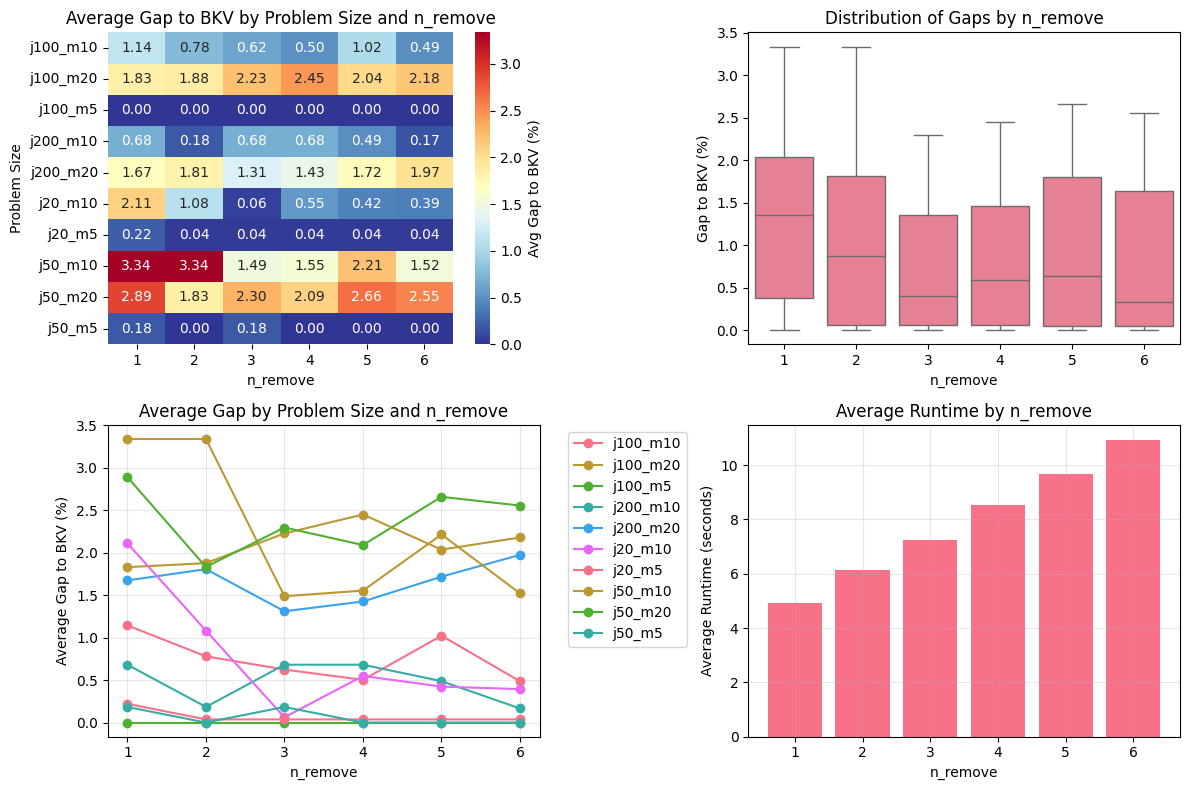

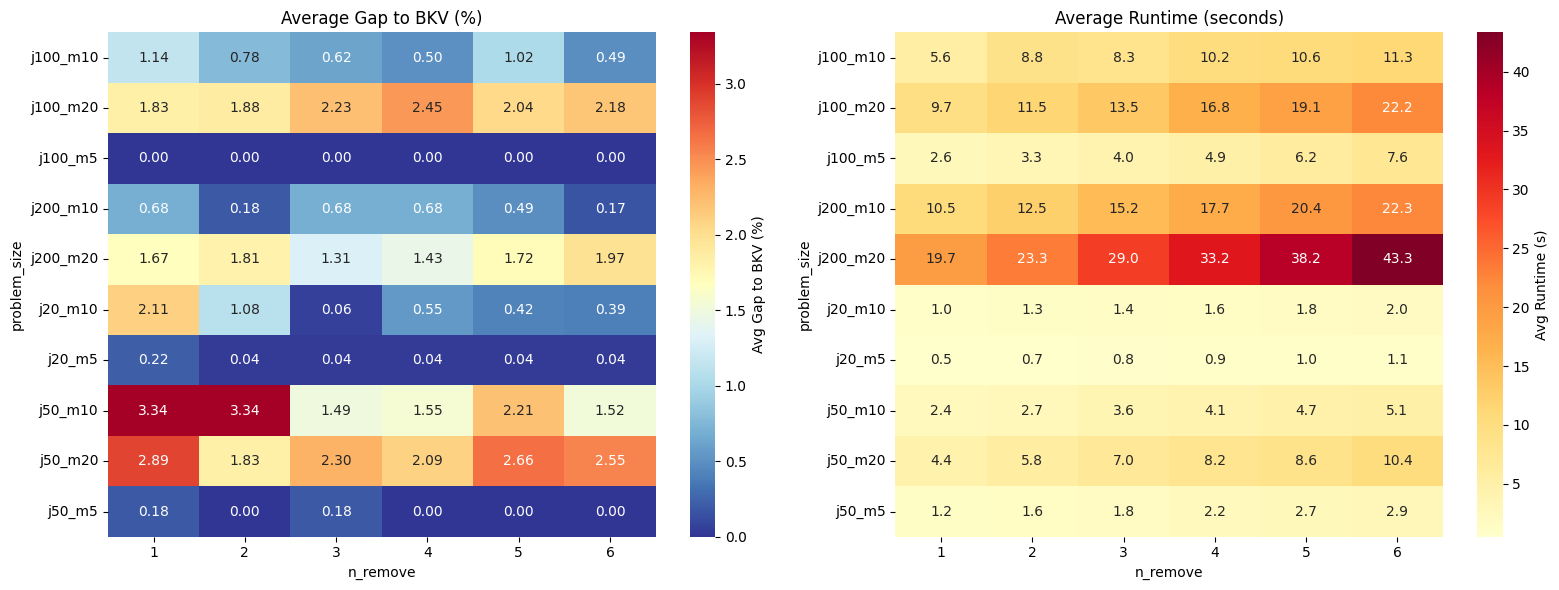

=== RECOMMENDATIONS ===

Overall best n_remove: 3 (average gap: 0.751%)

Recommended n_remove by problem size:
  j100_m10: n_remove = 6 (avg gap: 0.485%)
    Improvement over n_remove=2: 0.295 percentage points
  j100_m20: n_remove = 1 (avg gap: 1.829%)
    Improvement over n_remove=2: 0.048 percentage points
  j100_m5: n_remove = 1 (avg gap: 0.000%)
    Improvement over n_remove=2: 0.000 percentage points
  j200_m10: n_remove = 6 (avg gap: 0.166%)
    Improvement over n_remove=2: 0.018 percentage points
  j200_m20: n_remove = 3 (avg gap: 1.310%)
    Improvement over n_remove=2: 0.496 percentage points
  j20_m10: n_remove = 3 (avg gap: 0.062%)
    Improvement over n_remove=2: 1.021 percentage points
  j20_m5: n_remove = 2 (avg gap: 0.037%)
    Improvement over n_remove=2: 0.000 percentage points
  j50_m10: n_remove = 3 (avg gap: 1.488%)
    Improvement over n_remove=2: 1.851 percentage points
  j50_m20: n_remove = 2 (avg gap: 1.832%)
    Improvement over n_remove=2: 0.000 percentage po

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import time
from collections import defaultdict

def grid_search_n_remove(data_files, n_remove_values=[1, 2, 3, 4, 5], 
                         seed=SEED, iters=1000, max_instances_per_size=5):
    """
    Conduct a grid search to find optimal n_remove values for different problem sizes.
    
    Args:
        data_files: List of paths to problem instance files
        n_remove_values: List of n_remove values to test
        seed: Random seed for reproducibility
        iters: Number of iterations for each ALNS run
        max_instances_per_size: Maximum number of instances to test per problem size
    
    Returns:
        Dictionary containing grid search results
    """
    
    # Group data files by problem size
    size_groups = defaultdict(list)
    for file in data_files:
        instance_name = file.split('/')[-1].split('.')[0]
        problem_type = file.split('/')[-2]
        size_groups[problem_type].append(file)
    
    # Limit instances per size if specified
    if max_instances_per_size:
        for size in size_groups:
            size_groups[size] = size_groups[size][:max_instances_per_size]
    
    results = {
        'problem_size': [],
        'instance_name': [],
        'n_remove': [],
        'objective': [],
        'gap_to_bkv': [],
        'runtime': [],
        'bkv': []
    }
    
    print("Starting grid search for optimal n_remove values...")
    print(f"Testing n_remove values: {n_remove_values}")
    print(f"Problem sizes to test: {list(size_groups.keys())}")
    
    for problem_size, files in size_groups.items():
        print(f"\n=== Testing problem size: {problem_size} ===")
        
        for file_path in files:
            instance_name = file_path.split('/')[-1].split('.')[0]
            print(f"\n  Instance: {instance_name}")
            
            # Load data
            data = Data.from_file(file_path)
            global DATA
            DATA = data
            
            # Create initial solution using NEH
            init = NEH(data.processing_times)
            
            for n_remove in n_remove_values:
                print(f"    Testing n_remove={n_remove}...", end="")
                
                # Create destroy operators with current n_remove value
                def random_removal_n(state, rng, **kwargs):
                    return random_removal(state, rng, n_remove=n_remove)
                
                def adjacent_removal_n(state, rng, **kwargs):
                    return adjacent_removal(state, rng, n_remove=n_remove)
                
                
                # Setup ALNS with current n_remove
                alns = ALNS(rnd.default_rng(seed))
                
                # Add destroy operators with current n_remove
                alns.add_destroy_operator(random_removal_n)
                alns.add_destroy_operator(adjacent_removal_n)
                
                # Add repair operators
                alns.add_repair_operator(greedy_repair)
                
                # Configure ALNS parameters
                select = AlphaUCB(
                    scores=[5, 2, 1, 0.5],
                    alpha=0.05,
                    num_destroy=len(alns.destroy_operators),
                    num_repair=len(alns.repair_operators),
                )
                accept = SimulatedAnnealing.autofit(init.objective(), 0.05, 0.50, iters)
                stop = MaxIterations(iters)
                
                # Run ALNS
                start_time = time.time()
                result = alns.iterate(deepcopy(init), select, accept, stop)
                runtime = time.time() - start_time
                
                # Record results
                objective = result.best_state.objective()
                gap = 100 * (objective - data.bkv) / data.bkv
                
                results['problem_size'].append(problem_size)
                results['instance_name'].append(instance_name)
                results['n_remove'].append(n_remove)
                results['objective'].append(objective)
                results['gap_to_bkv'].append(gap)
                results['runtime'].append(runtime)
                results['bkv'].append(data.bkv)
                
                print(f" Obj: {objective}, Gap: {gap:.2f}%, Time: {runtime:.2f}s")
    
    return results

def analyze_grid_search_results(results):
    """
    Analyze and visualize the grid search results.
    """
    df = pd.DataFrame(results)
    
    print("=== GRID SEARCH RESULTS ANALYSIS ===\n")
    
    # 1. Overall best n_remove across all instances
    avg_performance = df.groupby('n_remove').agg({
        'gap_to_bkv': ['mean', 'std', 'min', 'max'],
        'runtime': 'mean'
    }).round(3)
    
    print("1. Overall Performance by n_remove:")
    print(avg_performance)
    print()
    
    # 2. Best n_remove by problem size
    size_performance = df.groupby(['problem_size', 'n_remove']).agg({
        'gap_to_bkv': 'mean',
        'runtime': 'mean'
    }).round(3)
    
    print("2. Performance by Problem Size and n_remove:")
    for size in df['problem_size'].unique():
        size_data = size_performance.loc[size]
        best_n_remove = size_data['gap_to_bkv'].idxmin()
        best_gap = size_data.loc[best_n_remove, 'gap_to_bkv']
        print(f"  {size}: Best n_remove = {best_n_remove} (avg gap: {best_gap:.3f}%)")
    print()
    
    # 3. Statistical significance test (if multiple instances per size)
    print("3. Detailed Results by Problem Size:")
    for size in sorted(df['problem_size'].unique()):
        print(f"\n  {size}:")
        size_df = df[df['problem_size'] == size]
        size_summary = size_df.groupby('n_remove').agg({
            'gap_to_bkv': ['mean', 'std', 'count'],
            'runtime': 'mean'
        }).round(3)
        print(size_summary)
    
    # 4. Create visualizations
    create_grid_search_visualizations(df)
    
    return df

def create_grid_search_visualizations(df):
    """
    Create comprehensive visualizations for the grid search results.
    """
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # 1. Heatmap of average gaps by problem size and n_remove
    plt.figure(figsize=(12, 8))
    
    pivot_table = df.groupby(['problem_size', 'n_remove'])['gap_to_bkv'].mean().unstack()
    
    plt.subplot(2, 2, 1)
    sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='RdYlBu_r', cbar_kws={'label': 'Avg Gap to BKV (%)'})
    plt.title('Average Gap to BKV by Problem Size and n_remove')
    plt.xlabel('n_remove')
    plt.ylabel('Problem Size')
    
    # 2. Box plot of gaps by n_remove
    plt.subplot(2, 2, 2)
    sns.boxplot(data=df, x='n_remove', y='gap_to_bkv')
    plt.title('Distribution of Gaps by n_remove')
    plt.xlabel('n_remove')
    plt.ylabel('Gap to BKV (%)')
    
    # 3. Line plot showing average performance by problem size
    plt.subplot(2, 2, 3)
    for size in sorted(df['problem_size'].unique()):
        size_data = df[df['problem_size'] == size].groupby('n_remove')['gap_to_bkv'].mean()
        plt.plot(size_data.index, size_data.values, marker='o', label=size)
    
    plt.title('Average Gap by Problem Size and n_remove')
    plt.xlabel('n_remove')
    plt.ylabel('Average Gap to BKV (%)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # 4. Runtime comparison
    plt.subplot(2, 2, 4)
    runtime_by_n_remove = df.groupby('n_remove')['runtime'].mean()
    plt.bar(runtime_by_n_remove.index, runtime_by_n_remove.values)
    plt.title('Average Runtime by n_remove')
    plt.xlabel('n_remove')
    plt.ylabel('Average Runtime (seconds)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 5. Detailed heatmap for each metric
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gap heatmap
    sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='RdYlBu_r', 
                ax=axes[0], cbar_kws={'label': 'Avg Gap to BKV (%)'})
    axes[0].set_title('Average Gap to BKV (%)')
    
    # Runtime heatmap
    runtime_pivot = df.groupby(['problem_size', 'n_remove'])['runtime'].mean().unstack()
    sns.heatmap(runtime_pivot, annot=True, fmt='.1f', cmap='YlOrRd', 
                ax=axes[1], cbar_kws={'label': 'Avg Runtime (s)'})
    axes[1].set_title('Average Runtime (seconds)')
    
    plt.tight_layout()
    plt.show()

def get_optimal_n_remove_recommendations(df):
    """
    Generate recommendations for optimal n_remove values.
    """
    print("=== RECOMMENDATIONS ===\n")
    
    # Overall best
    overall_best = df.groupby('n_remove')['gap_to_bkv'].mean().idxmin()
    overall_best_gap = df.groupby('n_remove')['gap_to_bkv'].mean().min()
    print(f"Overall best n_remove: {overall_best} (average gap: {overall_best_gap:.3f}%)")
    
    # Best by problem size
    print("\nRecommended n_remove by problem size:")
    recommendations = {}
    
    for size in sorted(df['problem_size'].unique()):
        size_data = df[df['problem_size'] == size]
        size_avg = size_data.groupby('n_remove')['gap_to_bkv'].mean()
        best_n_remove = size_avg.idxmin()
        best_gap = size_avg.min()
        
        recommendations[size] = {
            'n_remove': best_n_remove,
            'avg_gap': best_gap,
            'improvement_over_default': size_avg[2] - best_gap if 2 in size_avg.index else 0
        }
        
        print(f"  {size}: n_remove = {best_n_remove} (avg gap: {best_gap:.3f}%)")
        if 2 in size_avg.index:
            improvement = size_avg[2] - best_gap
            print(f"    Improvement over n_remove=2: {improvement:.3f} percentage points")
    
    return recommendations

# Example usage function
def run_grid_search_experiment():
    """
    Run the complete grid search experiment.
    """
    # Define smaller set of data files for quicker testing
    # You can expand this to include more instances
    quick_test_files = [
        "data/j20_m5/j20_m5_01.txt",
        "data/j20_m5/j20_m5_02.txt",
        "data/j20_m10/j20_m10_01.txt",
        "data/j20_m10/j20_m10_02.txt",
        "data/j50_m5/j50_m5_01.txt",
        "data/j50_m10/j50_m10_01.txt",
        "data/j50_m20/j50_m20_01.txt",
        "data/j100_m5/j100_m5_01.txt",
        "data/j100_m10/j100_m10_01.txt",
        "data/j100_m20/j100_m20_01.txt",
        "data/j200_m10/j200_m10_01.txt",
        "data/j200_m20/j200_m20_01.txt",
    ]
    
    # Run grid search
    results = grid_search_n_remove(
        data_files=quick_test_files,
        n_remove_values=[1, 2, 3, 4, 5, 6],
        seed=SEED,
        iters=1000,  # Reduced for quicker testing
        max_instances_per_size=2
    )
    
    # Analyze results
    df = analyze_grid_search_results(results)
    
    # Get recommendations
    recommendations = get_optimal_n_remove_recommendations(df)
    
    # Save results
    df.to_csv('n_remove_grid_search_results.csv', index=False)
    print(f"\nResults saved to 'n_remove_grid_search_results.csv'")
    
    return df, recommendations

# For comprehensive testing on all available instances
def run_comprehensive_grid_search():
    """
    Run grid search on all available instances (this will take longer).
    """
    # All data files
    data_files = []
    configurations = [
        (20, 5), (20, 10), (20, 20),
        (50, 5), (50, 10), (50, 20),
        (100, 5), (100, 10), (100, 20),
        (200, 10), (200, 20),
    ]
    
    for jobs, machines in configurations:
        for i in range(1, 11):  # All 10 instances per configuration
            data_files.append(f"data/j{jobs}_m{machines}/j{jobs}_m{machines}_{i:02d}.txt")
    
    results = grid_search_n_remove(
        data_files=data_files,
        n_remove_values=[1, 2, 3, 4, 5, 6, 7, 8],
        seed=SEED,
        iters=2000,
        max_instances_per_size=None  # Use all instances
    )
    
    df = analyze_grid_search_results(results)
    recommendations = get_optimal_n_remove_recommendations(df)
    
    df.to_csv('comprehensive_n_remove_grid_search_results.csv', index=False)
    print(f"\nComprehensive results saved to 'comprehensive_n_remove_grid_search_results.csv'")
    
    return df, recommendations

# Run the experiment
print("Choose experiment type:")
print("1. Quick test (few instances, faster)")
print("2. Comprehensive test (all instances, slower)")

# For quick testing, run:
df_results, recommendations = run_grid_search_experiment()

# For comprehensive testing, uncomment and run:
# df_results, recommendations = run_comprehensive_grid_search()